In [1]:
from builtins import range, input
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
 
from glob import glob
import pandas as pd
 
from sklearn.model_selection import train_test_split

In [2]:
import os
path = list()
target = list()
for root, _, filenames in os.walk('dataset'):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('jpeg'):
            full_path = os.path.join(root,filename)
            image_target_class = full_path.split('\\')[-2]
#             print(image_target_class)
#             print(os.path.join(root,filename))
            path.append(full_path)
            target.append(image_target_class)
print('Done!')

Done!


In [3]:
df = pd.DataFrame(data=zip(path,target),columns=['path','target'])
df.head()

,path,target
0,dataset\CT_COVID\1 (1).png,CT_COVID
1,dataset\CT_COVID\1 (10).png,CT_COVID
2,dataset\CT_COVID\1 (100).png,CT_COVID
3,dataset\CT_COVID\1 (101).png,CT_COVID
4,dataset\CT_COVID\1 (102).png,CT_COVID


In [4]:
df.groupby('target').count()

,path
target,
CT_COVID,349
CT_NonCOVID,397


In [5]:
train_df, valid_df = train_test_split(
    df,
    stratify = df['target'],
    test_size = 0.2,
    random_state=42
)


In [6]:
print(train_df.shape)
print(valid_df.shape)
print(train_df.target.value_counts())
print(valid_df.target.value_counts())

(596, 2)
(150, 2)
CT_NonCOVID    317
CT_COVID       279
Name: target, dtype: int64
CT_NonCOVID    80
CT_COVID       70
Name: target, dtype: int64


In [7]:
target_size = (124,124)
input_image_size = (124,124,3)
batch_size = 10

datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    horizontal_flip = True,
)

train_iterator = datagen.flow_from_dataframe(
    train_df,
    target_size = target_size,
    x_col='path',
    y_col='target',
    seed=42,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

validation_iterator = train_datagen.flow_from_dataframe(
    valid_df,
    target_size = target_size,
    x_col='path',
    y_col='target',
    seed=42,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

print(train_iterator)
print(validation_iterator)

Found 596 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.


In [8]:
# confirm the scaling works
batchX, batchY = train_iterator.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Batch shape=(10, 124, 124, 3), min=0.000, max=1.000


In [9]:
base_model = VGG19(
    input_shape = (124,124,3),
    include_top = False,
    weights = 'imagenet'
)
for layer in base_model.layers:
  layer.trainable = False

x = base_model.output
x = Flatten()(x)
# x = Dense(1024, activation = 'relu')(x)
# x = Dense(512,activation='relu')(x)
# x = Dense(64,activation='relu')(x)
x = Dropout(0.3)(x)
# x = Dense(32,activation='relu')(x)
# x = Dense(16,activation='relu')(x)
# x = Dense(8,activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)
model_final = Model(base_model.input,predictions)

model_final.compile(
    'adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./VGG19ModelCheckPoints/',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch'
)

In [11]:
hist = model_final.fit(
    train_iterator,
    validation_data = validation_iterator,
    steps_per_epoch = train_iterator.samples//train_iterator.batch_size,
    validation_steps = validation_iterator.samples//validation_iterator.batch_size,
    epochs = 200,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/200
59/59 [==============================] - 31s 517ms/step - loss: 0.7166 - accuracy: 0.5717 - val_loss: 0.6469 - val_accuracy: 0.6267
INFO:tensorflow:Assets written to: ./VGG19ModelCheckPoints\assets
Epoch 2/200
59/59 [==============================] - 30s 502ms/step - loss: 0.5391 - accuracy: 0.7389 - val_loss: 0.6036 - val_accuracy: 0.6600
INFO:tensorflow:Assets written to: ./VGG19ModelCheckPoints\assets
Epoch 3/200
59/59 [==============================] - 30s 505ms/step - loss: 0.5101 - accuracy: 0.7423 - val_loss: 0.5797 - val_accuracy: 0.7333
INFO:tensorflow:Assets written to: ./VGG19ModelCheckPoints\assets
Epoch 4/200
59/59 [==============================] - 29s 500ms/step - loss: 0.4228 - accuracy: 0.8072 - val_loss: 0.5948 - val_accuracy: 0.6800
Epoch 5/200
59/59 [==============================] - 30s 503ms/step - loss: 0.4045 - accuracy: 0.8242 - val_loss: 0.5629 - val_accuracy: 0.7467
INFO:tensorflow:Assets written to: ./VGG19ModelCheckPoints\assets
Epoch 6/200
59/5

In [12]:
model_final.save('myvgg19.h5')

In [13]:
model_final.save('vgg19Model')

INFO:tensorflow:Assets written to: vgg19Model\assets


In [14]:
# evaluating validation data on the model
model_final.evaluate_generator(
    generator=validation_iterator,
    steps=validation_iterator.samples//validation_iterator.batch_size,
    verbose=1
)

C:\Users\ankit.dubey\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


15/15 [==============================] - 6s 410ms/step - loss: 0.7512 - accuracy: 0.7533


[0.7512083053588867, 0.753333330154419]

# Plotting Model Loss & Accuracy 

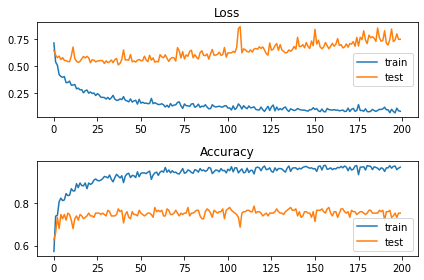

In [15]:
plt.subplot(211)
plt.title('Loss')
plt.plot(hist.history['loss'],label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='test')
plt.legend()
plt.tight_layout()
plt.show()

# Model Performance Analysis

In [16]:
# predicting on the validation images
preds_on_validation_data = model_final.predict(validation_iterator)
len(preds_on_validation_data)
# getting the maximum probabilites among the predicted one
max_pred_on_validation_data = np.argmax(preds_on_validation_data,axis=1)
max_pred_on_validation_data[:10]

array([0, 0, 1, 1, 0, 1, 1, 0, 0, 0], dtype=int64)

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(validation_iterator.classes, max_pred_on_validation_data))
mat = confusion_matrix(validation_iterator.classes, max_pred_on_validation_data)
print('Classification Report')
target_names = ['Negative', 'Positive']
print(classification_report(validation_iterator.classes, max_pred_on_validation_data, target_names=target_names))

Confusion Matrix
[[28 42]
 [35 45]]
Classification Report
              precision    recall  f1-score   support

    Negative       0.44      0.40      0.42        70
    Positive       0.52      0.56      0.54        80

    accuracy                           0.49       150
   macro avg       0.48      0.48      0.48       150
weighted avg       0.48      0.49      0.48       150



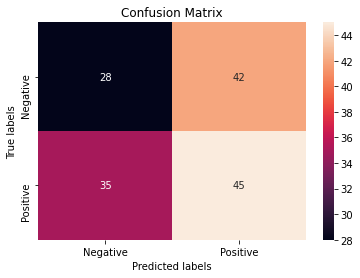

In [18]:
ax= plt.subplot()
sns.heatmap(mat, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Negative', 'Positive']); ax.yaxis.set_ticklabels(['Negative', 'Positive']);

# Testing on whole dataset

In [23]:
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df,
    x_col='path',
    y_col='target',
    batch_size=10,
    seed=42,
    shuffle=False,
    class_mode='categorical',
    target_size=(124,124)
)

Found 746 validated image filenames belonging to 2 classes.


In [24]:
model_final.evaluate_generator(
    generator=test_generator,
    steps=test_generator.samples//test_generator.batch_size
)

C:\Users\ankit.dubey\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.17204608023166656, 0.9486486315727234]

In [25]:
preds = model_final.predict(test_generator)
len(preds)
# predictions for test data
pred = np.argmax(preds,axis=1)
pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [26]:
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, pred))
mat = confusion_matrix(test_generator.classes, pred)
print('Classification Report')
target_names = ['Negative', 'Positive']
print(classification_report(test_generator.classes, pred, target_names=target_names))

Confusion Matrix
[[326  23]
 [ 15 382]]
Classification Report
              precision    recall  f1-score   support

    Negative       0.96      0.93      0.94       349
    Positive       0.94      0.96      0.95       397

    accuracy                           0.95       746
   macro avg       0.95      0.95      0.95       746
weighted avg       0.95      0.95      0.95       746



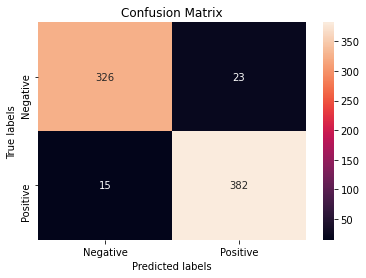

In [27]:
ax= plt.subplot()
sns.heatmap(mat, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Negative', 'Positive']); ax.yaxis.set_ticklabels(['Negative', 'Positive']);

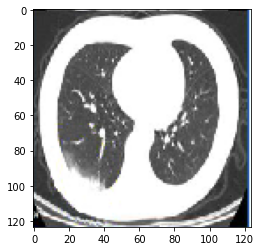

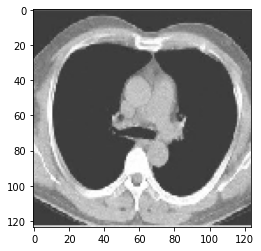

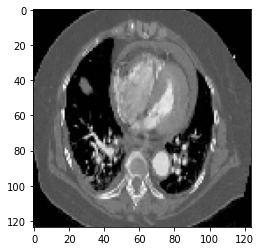

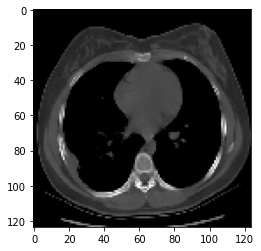

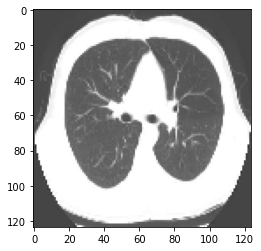

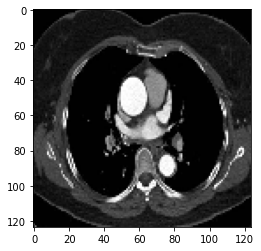

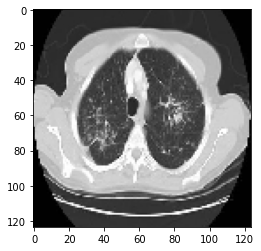

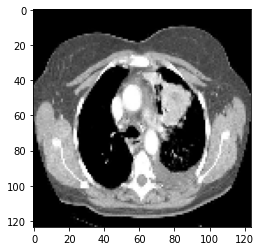

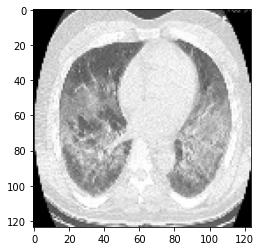

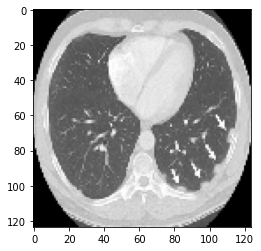

In [70]:
for i in range(10):
    img,label = test_generator.next()
    plt.imshow(img[0])
    plt.show()

In [73]:
final_outcomes = zip(df['target'],pred,test_generator.classes)

In [75]:
final_df = pd.DataFrame(final_outcomes,columns=['actual target','Predicted target','classes'])
final_df.head(10)

,actual target,Predicted target,classes
0,CT_COVID,0,0
1,CT_COVID,0,0
2,CT_COVID,0,0
3,CT_COVID,0,0
4,CT_COVID,0,0
5,CT_COVID,0,0
6,CT_COVID,0,0
7,CT_COVID,0,0
8,CT_COVID,0,0
9,CT_COVID,0,0


In [76]:
final_df.tail(10)

,actual target,Predicted target,classes
736,CT_NonCOVID,1,1
737,CT_NonCOVID,1,1
738,CT_NonCOVID,1,1
739,CT_NonCOVID,1,1
740,CT_NonCOVID,1,1
741,CT_NonCOVID,1,1
742,CT_NonCOVID,1,1
743,CT_NonCOVID,1,1
744,CT_NonCOVID,1,1
745,CT_NonCOVID,1,1


In [77]:
test_generator.class_indices

{'CT_COVID': 0, 'CT_NonCOVID': 1}